# Introduction to Convolutional Neural Networks with Keras 

### The data set used: CIFAR10
https://www.cs.toronto.edu/~kriz/cifar.html

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Input, Dense, MaxPooling2D, Flatten, Conv2D, ZeroPadding2D, BatchNormalization, Activation
from keras.datasets import cifar10
from keras import optimizers, losses
from keras.models import Model
import keras.utils
from keras.utils import to_categorical
from keras import utils as np_utils
from keras.models import model_from_json
import time
%matplotlib inline

In [28]:
#load the data, we won't use now the test set
(x_train, y_train), ( x_test , y_test) = cifar10.load_data() #the _ indicates we don't want that value

## Understanding the data_set
The training set has 50000 images RGB each of shape 32x32x3 (x_train) and 5000 labels (y_train). 
The test set has 1000 images with the same especifications.
0. airplane 										
1. automobile 										
2. bird 										
3. cat 										
4. deer 										
5. dog 										
6. frog 										
7. horse 										
8. ship 										
9. truck 										
 

In [29]:
#Dividing the training set into test set and validation set
x_validation = x_train[45000:50000]
y_validation = y_train[45000: 50000]
x_train = x_train[0:45000]
y_train = y_train[0: 45000]

label:  [9] truck
x_train.shape =  (45000, 32, 32, 3)
y_train.shape =  (45000, 1)
x_validation.shape =  (5000, 32, 32, 3)
y_validation.shape =  (5000, 1)
x_test.shape =  (10000, 32, 32, 3)
y_test.shape =  (10000, 1)
number of classes:  10


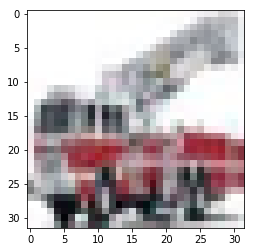

In [30]:
#Extracting sizes
m = x_train.shape[0]
width =  x_train.shape[2] #the width is the number of columns
height = x_train.shape[1] #the height is the number of lines
n_C = x_train.shape[3]

#View the data
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
index = np.random.randint(m)
img = x_train[index]
print("label: ", y_train[index], classes[int(y_train[index])])
imgplot = plt.imshow(img)

print ("x_train.shape = ", x_train.shape)
print("y_train.shape = ", y_train.shape)
print("x_validation.shape = ", x_validation.shape)
print("y_validation.shape = ", y_validation.shape)
print("x_test.shape = ", x_test.shape)
print("y_test.shape = ", y_test.shape)
print("number of classes: ", np.max(y_train) + 1)

## Conv2D
**keras.layers.Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)**  
2D convolution layer (e.g. spatial convolution over images).

This layer creates a convolution kernel that is convolved with the layer input to produce a tensor of outputs. If use_bias is True, a bias vector is created and added to the outputs. Finally, if activation is not None, it is applied to the outputs as well.

When using this layer as the first layer in a model, provide the keyword argument input_shape (tuple of integers, does not include the sample axis), e.g. input_shape=(128, 128, 3) for 128x128 RGB pictures in data_format="channels_last".


* filters: Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution).
* kernel_size: An integer or tuple/list of 2 integers, specifying the height and width of the 2D convolution window. Can be a single integer to specify the same value for all spatial dimensions.
* strides: An integer or tuple/list of 2 integers, specifying the strides of the convolution along the height and width. Can be a single integer to specify the same value for all spatial dimensions. Specifying any stride value != 1 is incompatible with specifying any dilation_rate value != 1.
* padding: one of "valid" or "same" (case-insensitive).
    
https://keras.io/layers/convolutional/

## My ConvModel
input => 16 filters of 3x3 stride 1, no padding => 1 POOL layer 2x2 stride 2 => 8 filters 5x5x16 stride 2 = Flatten =>
volume.reshape(volume.shape[0], -1).T => FC 20 nodes => softmax() with 10 outputs. 
Some things to look carefully:

In [31]:
def first_model(): 
    model = Sequential()
    #layer 1
    initializer = keras.initializers.he_normal(1)
    model.add(Conv2D(16, 3, strides = 1, input_shape = x_train[0].shape,
                     padding = 'valid', activation = 'relu', kernel_initializer = initializer))
    #layer 2
    model.add(MaxPooling2D(pool_size=(4, 4), strides=(2, 2)))
    #layer 3
    model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer = initializer))
    model.add(Flatten())
    #layer 4
    model.add(Dense(30, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [32]:
#PAD (3,3) -> CONV2D (7X7,32) -> BN -> RELU -> MAXPOOL (2,2) ->FLATTEN
#->SIGMOID
def HappyModel(input_shape):
    """
    Implementation of the HappyModel.
    
    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in Keras
    """
    
    #LET'S TRY THE EASY
    #Define the input
    X_input = Input(input_shape)
    
    #Zero-padding: pads the border of X_input with zeros
    X = ZeroPadding2D((3,3))(X_input)
    
    #CONV2D: uses 32 filters 7x7
    X = Conv2D(32,(7,7), strides = (1,1), name = 'conv0')(X)
    #BN
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    #RELU
    X = Activation('relu')(X)
    #MAXPOOL
    X = MaxPooling2D((2,2), name = 'max_pool')(X)
    
    #FLATTEN X (CONVERT TO VECTOR) -> fully connected layer
    X = Flatten()(X)
    X = Dense(10, activation='softmax', name ='fc')(X)
    
    #creates the model
    model = Model(inputs = X_input, outputs = X, name = 'HappyModel')
    ### END CODE HERE ###
    
    return model

## Compiling
Used Adam optimizer. Too see other [possibilities](https://keras.io/optimizers/)

In [33]:
#learning rate
lr = 0.00001
model = HappyModel((32,32,3))
optimizer = keras.optimizers.Nadam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer= optimizer,
              metrics=['accuracy'])


## Use one hot enconding
Why use one hor enconding?
The categorical varibles representation become more expressive.  
See the refference to implementations in some frameworks.
https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/

## Traning model:

In [34]:
#uses one hot encoding on the labels
y_train_encoded = to_categorical(y_train)
y_validation_encoded = to_categorical(y_validation)
y_test_encoded = to_categorical(y_test)


batch_size = 32 #this is the default by the way
epochs = 10
tic = time.time()
history = model.fit(x_train, y_train_encoded,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          )
toc = time.time()
elapsed_time = toc - tic
print("Elapsed time: ", elapsed_time)

Epoch 1/10
45000/45000 [==============================] - 78s 2ms/step - loss: 1.9974 - acc: 0.2883
Epoch 2/10
45000/45000 [==============================] - 75s 2ms/step - loss: 1.7081 - acc: 0.3994
Epoch 3/10
45000/45000 [==============================] - 77s 2ms/step - loss: 1.6057 - acc: 0.4400
Epoch 4/10
45000/45000 [==============================] - 78s 2ms/step - loss: 1.5392 - acc: 0.4639
Epoch 5/10
45000/45000 [==============================] - 78s 2ms/step - loss: 1.4877 - acc: 0.4831
Epoch 6/10
45000/45000 [==============================] - 80s 2ms/step - loss: 1.4465 - acc: 0.4963
Epoch 7/10
45000/45000 [==============================] - 78s 2ms/step - loss: 1.4111 - acc: 0.5119
Epoch 8/10
45000/45000 [==============================] - 79s 2ms/step - loss: 1.3786 - acc: 0.5228
Epoch 9/10
45000/45000 [==============================] - 79s 2ms/step - loss: 1.3481 - acc: 0.5327
Epoch 10/10
45000/45000 [==============================] - 79s 2ms/step - loss: 1.3221 - acc: 0.5443

## Visualizing the Results
1. Plot the accuracy per epoch
2. Plot the cost function per epoch

dict_keys(['loss', 'acc'])


KeyError: 'val_acc'

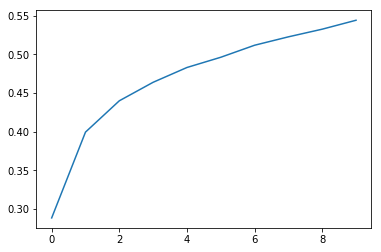

In [36]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Loading and evaluating weights and model from the disk

In [ ]:
def load_model(model_name):
    # load json and create model
    json_file = open(model_name + '.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(model_name ".h5")
    print("Loaded model from disk")
    return loaded_model

# #EVALUATE MODEL
# # evaluate loaded model on test data
# lr = 0.00000005
# optimizer = keras.optimizers.Nadam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
# loaded_model.compile(loss=keras.losses.categorical_crossentropy,
#               optimizer= optimizer,
#               metrics=['accuracy'])
# score = loaded_model.evaluate(x_test, y_test_encoded, verbose=0)
# print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

In [37]:
score = model.evaluate(x_test, y_test_encoded, verbose=0)
## Prediction time
index = np.random.randint(x_test.shape[0])
X_predict = x_test[index]
x_shape = X_predict.shape
X_predict = X_predict.reshape((1, X_predict.shape[0], X_predict.shape[1], X_predict.shape[2]))
y_predict = model.predict_classes(X_predict)
y_predict = int(y_predict.reshape(1))
print("The prediction: ", y_predict, classes[y_predict])
print( "The label: ", y_test[index], classes[int(y_test[index])])
plt.imshow(X_predict.reshape(x_shape))



AttributeError: 'Model' object has no attribute 'predict_classes'

## Saving model and weights to disk

Tutorial to save the model and the weights to disk.
https://machinelearningmastery.com/save-load-keras-deep-learning-models/

In [ ]:
def serialize_model(model, model_name):
    """
    Arguments: model_name - Sring
    Saves the model in a file .json and the weights in a .h5 file
    """
    model_json = model_name + ".json"
    model_h5 = model_name + ".h5"
    # serialize model to JSON
    model_json = model.to_json()
    with open(model_name + ".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(model_name + ".h5")
    print("Saved model to disk")

In [ ]:
serialize_model(HappyModel, "happy_model")

## References:
http://adventuresinmachinelearning.com/keras-tutorial-cnn-11-lines/
https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/
https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/

Initialize parameters:
https://keras.io/optimizers/

Optimizers:
https://keras.io/optimizers/

Counting time:  
https://stackoverflow.com/questions/3620943/measuring-elapsed-time-with-the-time-module

Visualizing the data:  
https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

Making predictions:
https://machinelearningmastery.com/how-to-make-classification-and-regression-predictions-for-deep-learning-models-in-keras/

## Problems:
**In exp02**:
Add he-inititializer, use the training set with 45000 examples and the validation set with 5000.
Why change: I think the model is falling at breaking symetry. (it didn't break symetry)

**In exp03**:
keras.optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004.The cost does not get lower on epochs. Possilble problem, gradient vanishing. Solution: ResNet?
**In exp04**: increase number of neurons in the FC layer.
